# Notebook 03 - Data Analysis

## Objectives

* Analyse data to answer business requirement 1: the client is interested in determining which variables correlate with a default payment in the following month

## Inputs

* CSV file with cleaned data generated in previous notebook: outputs/datasets/cleaned/v1/credit_card_data_cleaned.csv

## Outputs

* Generate code that answers business requirement 1 and can be used to build Streamlit app
* [LIST] Plots saved in folder as documentation

## [UPDATE] Additional Comments / Conclusions

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

* This notebook is stored in the `jupyter_notebooks` subfolder
* The current working directory therefore needs to be changed to the workspace, i.e., the working directory needs to be changed from the current folder to its parent folder

Firstly, the current directory is accessed with os.getcwd()

In [3]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\franc\\credit-card-default\\jupyter_notebooks'

Next, the working directory is set as the parent of the current `jupyter_notebooks` directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory
* This allows access to all the files and folders within the workspace, rather than solely those within the `jupyter_notebooks` directory

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Finally, confirm that the new current directory has been successfully set

In [5]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\franc\\credit-card-default'

---

# Load data

The data is loaded from the outputs/datasets/cleaned/v1 folder:

In [6]:
import pandas as pd
df = pd.read_csv('outputs/datasets/cleaned/v1/credit_card_data_cleaned.csv')
df.head()

credit_limit     sex   education marital_status  age  late_sep  late_aug  \
0       20000.0  female  university        married   24         2         2   
1      120000.0  female  university         single   26        -1         2   
2       90000.0  female  university         single   34         0         0   
3       50000.0  female  university        married   37         0         0   
4       50000.0    male  university        married   57        -1         0   

   late_jul  late_jun  late_may  ...  prev_payment_sep  prev_payment_aug  \
0        -1        -1        -2  ...               0.0             689.0   
1         0         0         0  ...               0.0            1000.0   
2         0         0         0  ...            1518.0            1500.0   
3         0         0         0  ...            2000.0            2019.0   
4        -1         0         0  ...            2000.0           36681.0   

   prev_payment_jul  prev_payment_jun  prev_payment_may  prev_payment_apr  \
0               0.0               0.0               0.0               0.0   
1            1000.0            1000.0               0.0            2000.0   
2            1000.0            1000.0            1000.0            5000.0   
3            1200.0            1100.0            1069.0            1000.0   
4           10000.0            9000.0             689.0             679.0   

   default_next_month  any_default  total_default  greatest_default  
0                   1            1              4                 2  
1                   1            1              4                 2  
2                   0            0              0                 0  
3                   0            0              0                 0  
4                   0            0              0                 0  

[5 rows x 27 columns]

---

# Data Exploration 1: Pandas Profile Report

In order to become more familiar with the dataset, we can create a Pandas profile report:

In [7]:
from pandas_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Pandas profile report discussion

In the `credit_limit` feature, we see that the data is somewhat positively skewed, with a skewness value very close to 1
* 1 (for positive skew) or -1 (for negative skew) is often used as the cut off between 'slightly' and 'very' skewed
* Intuitively we expect the data to be positively skewed, since most customers will start out with a low credit limit; credit limit tends only to be increased upon request and / or after enough time has elapsed where a customer has demonstrated a consistent ability not to default on payment
  
The `sex` data appears at first sight to be slightly imbalanced, with more female than male customers
- For ML purposes, this asymmetry may not be great enough to be problematic; [Google](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data) note that in a dataset with a mild degree of imbalance, the minority class makes up 20-40% of the dataset, whereas in the current data, the minority class is well over half the size of the majority

The `education` column is more imbalanced: customers with high school education only are in a clear minority relative to those who have education at university level or above. This could be an issue since it could cause an ML model that uses education level as an input to predict default behaviour more accurately for university-educated customers than those with only high school education

The `marital_status` column is well-balanced between single and married customers, although those with another status are not well represented in the data

The graph for `age` is unusual, with spikes in the data every 6-7 years that appear to be roughly proportionate to the size of their surrounding age values but around 2 - 2.5 times their value
* Without being able to obtain more information, this is hard to explain
* The data could in theory be genuine, for example if the credit card company aggressively marketed to customers who had just reached the age where they could obtain a credit card once every few years
    - However, it is hard to see a reason why this would only be done intermittently
* It is also difficult to ascribe this to a data recording error or sampling bias, since the problem is systematic and consistent across different age bands
* It seems most likely that data has been rounded, estimated or grouped in some way that has not been recorded
* Ideally we would go back to the client and ask for more clarity around the data, however in this case this has not been possible
  
The graphs relating to late payment, from `late_sep` to `late_apr` look relatively consistent with each other, except that September is the only month with a significant number of customers who had a payment delay for one month - we would expect this to be the most common payment delay and to be consistent across the timeframe
* Again, in an ideal situation we would like to gain further information around the data that might help explain this
* However, the graphs otherwise look consistent and make intuitive sense, with values of 0, -1 or -2 (corresponding to non-default behaviour) being by far the most common values, and a sharp dropoff in the number of months by which payment is late after 2

The amount of the bill statement columns, from `bill_sep` to `bill_apr` look consistent with each other and look realistic, with positive skewness as the majority of customers spend relatively modest amounts
* The higher the value of the bill statement, the smaller the number of customers with that amount
* Some months show negative values, however, in practice this is to be expected as a refund that exceeds customer spend in a given month would put the account into credit

The graphs showing the amount of the previous payment, `prev_payment_sep` to `prev_payment_apr`, are consistent with each other and show very high positive skewness and kurtosis, with the majority of customers having made a relatively small payment in the previous month but also outliers who have made much higher payments

The target variable of `default_next_month` is, as expected, significantly skewed, with the majority of customers not defaulting on their payment the following month
* Although this is expected, it will need to be taken into consideration when building an ML model to avoid developing a model that is biased towards the majority class (no default)

The newly created variables are `any_default`, `total_default` and `greatest_default`
* All three have the same number of zeros, with customers who have defaulted in some manner during the last six months representing just over a third of the total sample
    - This is most clearly seen in the `any_default` graph, where it can be seen that although the majority of customers have not defaulted, a sizeable minority has
* In `total_default` and `greatest_default` we see the same systematic lack of customers who had a single default; the value 2 is more commonly found in both of these graphs than the value 1
    - We would expect 1 to be by far the most common value, where an otherwise compliant customer misses a single payment due to oversight or some other issue
    - Since we cannot solve this issue we will have to accept it as a limitation of the current dataset




---

# Data Exploration 2: Correlation Study

The dataset has a number of categorical variables. These can be transformed using [One Hot Encoding](https://feature-engine.trainindata.com/en/1.1.x/encoding/OneHotEncoder.html).
* Note that One Hot Encoding is preferred in machine learning to the numerical values that were present in the initial dataset because it avoids a situation where a model can add bias by giving preference to labels encoded as higher numbers, when in fact we want all labels to be equally important in the dataset

In [8]:
from feature_engine.encoding import OneHotEncoder
encoder = OneHotEncoder(variables=df.columns[df.dtypes=='object'].to_list(), drop_last=False)
df_ohe = encoder.fit_transform(df)
df_ohe.head()

credit_limit  age  late_sep  late_aug  late_jul  late_jun  late_may  \
0       20000.0   24         2         2        -1        -1        -2   
1      120000.0   26        -1         2         0         0         0   
2       90000.0   34         0         0         0         0         0   
3       50000.0   37         0         0         0         0         0   
4       50000.0   57        -1         0        -1         0         0   

   late_apr  bill_sep  bill_aug  ...  education_university  \
0        -2    3913.0    3102.0  ...                     1   
1         2    2682.0    1725.0  ...                     1   
2         0   29239.0   14027.0  ...                     1   
3         0   46990.0   48233.0  ...                     1   
4         0    8617.0    5670.0  ...                     1   

   education_graduate school  education_high school  education_unknown  \
0                          0                      0                  0   
1                          0                      0                  0   
2                          0                      0                  0   
3                          0                      0                  0   
4                          0                      0                  0   

   education_other  education_0  marital_status_married  \
0                0            0                       1   
1                0            0                       0   
2                0            0                       0   
3                0            0                       1   
4                0            0                       1   

   marital_status_single  marital_status_other  marital_status_unknown  
0                      0                     0                       0  
1                      1                     0                       0  
2                      1                     0                       0  
3                      0                     0                       0  
4                      0                     0                       0  

[5 rows x 36 columns]

As expected, the number of columns in the dataframe has increased when OHE is applied. However, at 36 columns it is still a manageable size.

The `pearson` and `spearman` methods can now be used with `.corr()` to investigate the linear and monotonic correlations, respectively, with default behaviour:

In [9]:
corr_pearson = df_ohe.corr(method='pearson')['default_next_month'].sort_values(key=abs, ascending=False)[1:]
corr_pearson

total_default                0.376034
greatest_default             0.370388
any_default                  0.352858
late_sep                     0.324794
late_aug                     0.263551
late_jul                     0.235253
late_jun                     0.216614
late_may                     0.204149
late_apr                     0.186866
credit_limit                -0.153520
prev_payment_sep            -0.072929
prev_payment_aug            -0.058579
prev_payment_jun            -0.056827
prev_payment_jul            -0.056250
prev_payment_may            -0.055124
prev_payment_apr            -0.053183
education_graduate school   -0.051328
sex_male                     0.039961
sex_female                  -0.039961
education_university         0.036467
education_unknown           -0.036302
education_high school        0.032403
marital_status_single       -0.030619
marital_status_married       0.029775
education_other             -0.025397
bill_sep                    -0.019644
bill_aug    

In [10]:
corr_spearman = df_ohe.corr(method='spearman')['default_next_month'].sort_values(key=abs, ascending=False)[1:]
corr_spearman

total_default                0.390394
greatest_default             0.372802
any_default                  0.352858
late_sep                     0.292213
late_aug                     0.216919
late_jul                     0.194771
late_jun                     0.173690
credit_limit                -0.169586
prev_payment_sep            -0.160493
late_may                     0.159043
prev_payment_aug            -0.150977
late_apr                     0.142523
prev_payment_jul            -0.139388
prev_payment_jun            -0.127979
prev_payment_apr            -0.121444
prev_payment_may            -0.116587
education_graduate school   -0.051328
sex_female                  -0.039961
sex_male                     0.039961
education_university         0.036467
education_unknown           -0.036302
education_high school        0.032403
marital_status_single       -0.030619
marital_status_married       0.029775
education_other             -0.025397
bill_sep                    -0.025327
bill_aug    

For both methods, the levels of correlation between `default_next_month` and other variables range from extremely weak to moderate. This is not ideal but the newly created categories do, as expected, consistently show the highest correlation with future default.

The top five correlation levels can be calculated as follows:

In [11]:
top_n = 5
set(corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list())

{'any_default', 'greatest_default', 'late_aug', 'late_sep', 'total_default'}

However, since `late_aug` and `late_sep` are components of the other three variables, as well as being the two of these five with the lowest levels of correlation, we might not choose to include them in the analysis.
* We might choose instead to consider `credit_limit`, since across both `pearson` and `spearman` methods, it has the highest correlation to future default of the variables that have not been incorporated into `any_default`, `total_default` and `greatest_default`
* We could investigate whether a customer who defaults in the following month typically has:
    - A high total default score, `total_default`
    - A high value for their largest single default, `greatest_default`
    - A history of any previous default, `any_default`
    - A lower credit limit, `credit_limit`  

However, before proceeding with this analysis, we can also assess the Predictive Power Score of the features with the target variable.

---

# Data Exploration 3: Predictive Power Score Analysis

The Predictive Power Score matrix for the dataset is calculated with `pps.matrix()`
* For more information on PPS, see the [documentation](https://github.com/8080labs/ppscore)
* PPS' creators note that "The PPS is an asymmetric, data-type-agnostic score that can detect linear or non-linear relationships between two columns. The score ranges from 0 (no predictive power) to 1 (perfect predictive power). It can be used as an alternative to the correlation (matrix)."

In [12]:
import ppscore as pps
pps.predictors(df, "default_next_month", sample=30000)

x                   y  ppscore        case  is_valid_score  \
0       credit_limit  default_next_month        0  regression            True   
1                sex  default_next_month        0  regression            True   
2          education  default_next_month        0  regression            True   
3     marital_status  default_next_month        0  regression            True   
4                age  default_next_month        0  regression            True   
5           late_sep  default_next_month        0  regression            True   
6           late_aug  default_next_month        0  regression            True   
7           late_jul  default_next_month        0  regression            True   
8           late_jun  default_next_month        0  regression            True   
9           late_may  default_next_month        0  regression            True   
10          late_apr  default_next_month        0  regression            True   
11          bill_sep  default_next_month        0  regression            True   
12          bill_aug  default_next_month        0  regression            True   
13          bill_jul  default_next_month        0  regression            True   
14          bill_jun  default_next_month        0  regression            True   
15          bill_may  default_next_month        0  regression            True   
16          bill_apr  default_next_month        0  regression            True   
17  prev_payment_sep  default_next_month        0  regression            True   
18  prev_payment_aug  default_next_month        0  regression            True   
19  prev_payment_jul  default_next_month        0  regression            True   
20  prev_payment_jun  default_next_month        0  regression            True   
21  prev_payment_may  default_next_month        0  regression            True   
22  prev_payment_apr  default_next_month        0  regression            True   
23       any_default  default_next_month        0  regression            True   
24     total_default  default_next_month        0  regression            True   
25  greatest_default  default_next_month        0  regression            True   

                 metric  baseline_score  model_score                    model  
0   mean absolute error          0.2212     0.333557  DecisionTreeRegressor()  
1   mean absolute error          0.2212     0.344003  DecisionTreeRegressor()  
2   mean absolute error          0.2212     0.342733  DecisionTreeRegressor()  
3   mean absolute error          0.2212     0.344157  DecisionTreeRegressor()  
4   mean absolute error          0.2212     0.343275  DecisionTreeRegressor()  
5   mean absolute error          0.2212     0.283049  DecisionTreeRegressor()  
6   mean absolute error          0.2212     0.304799  DecisionTreeRegressor()  
7   mean absolute error          0.2212     0.314656  DecisionTreeRegressor()  
8   mean absolute error          0.2212     0.317910  DecisionTreeRegressor()  
9   mean absolute error          0.2212     0.319460  DecisionTreeRegressor()  
10  mean absolute error          0.2212     0.323074  DecisionTreeRegressor()  
11  mean absolute error          0.2212     0.340926  DecisionTreeRegressor()  
12  mean absolute error          0.2212     0.339993  DecisionTreeRegressor()  
13  mean absolute error          0.2212     0.341993  DecisionTreeRegressor()  
14  mean absolute error          0.2212     0.337965  DecisionTreeRegressor()  
15  mean absolute error          0.2212     0.340640  DecisionTreeRegressor()  
16  mean absolute error          0.2212     0.342158  DecisionTreeRegressor()  
17  mean absolute error          0.2212     0.331446  DecisionTreeRegressor()  
18  mean absolute error          0.2212     0.332925  DecisionTreeRegressor()  
19  mean absolute error          0.2212     0.334299  DecisionTreeRegressor()  
20  mean absolute error          0.2212     0.333460  DecisionTreeRegressor()  
21  mean absolute error          0.2212     0.335378  DecisionTreeRegre

We see here that the PPS model has interpreted the task as regression rather than classification
* From the documentation it can be seen that because the `Dtype` is `int64` a regression will be chosen by the model
* We can address this by creating a new dataframe that changes the `Dtype` to `boolean:`

In [13]:
df_pps = df.copy()
df_pps['default_next_month_bool'] = df['default_next_month'].map({0: False, 1: True})
df_pps = df_pps.drop('default_next_month', axis=1)
pps_matrix = pps.predictors(df_pps, "default_next_month_bool", sample=30000)
pps_matrix

x                        y   ppscore            case  \
0           late_sep  default_next_month_bool  0.348139  classification   
1           late_aug  default_next_month_bool  0.307570  classification   
2      total_default  default_next_month_bool  0.301372  classification   
3           late_jul  default_next_month_bool  0.264145  classification   
4           late_jun  default_next_month_bool  0.245785  classification   
5           late_may  default_next_month_bool  0.236554  classification   
6           late_apr  default_next_month_bool  0.167098  classification   
7   greatest_default  default_next_month_bool  0.137385  classification   
8                age  default_next_month_bool  0.000146  classification   
9       credit_limit  default_next_month_bool  0.000000  classification   
10               sex  default_next_month_bool  0.000000  classification   
11         education  default_next_month_bool  0.000000  classification   
12    marital_status  default_next_month_bool  0.000000  classification   
13          bill_sep  default_next_month_bool  0.000000  classification   
14          bill_aug  default_next_month_bool  0.000000  classification   
15          bill_jul  default_next_month_bool  0.000000  classification   
16          bill_jun  default_next_month_bool  0.000000  classification   
17          bill_may  default_next_month_bool  0.000000  classification   
18          bill_apr  default_next_month_bool  0.000000  classification   
19  prev_payment_sep  default_next_month_bool  0.000000  classification   
20  prev_payment_aug  default_next_month_bool  0.000000  classification   
21  prev_payment_jul  default_next_month_bool  0.000000  classification   
22  prev_payment_jun  default_next_month_bool  0.000000  classification   
23  prev_payment_may  default_next_month_bool  0.000000  classification   
24  prev_payment_apr  default_next_month_bool  0.000000  classification   
25       any_default  default_next_month_bool  0.000000  classification   

    is_valid_score       metric  baseline_score  model_score  \
0             True  weighted F1        0.681953     0.792678   
1             True  weighted F1        0.681953     0.779775   
2             True  weighted F1        0.681953     0.777804   
3             True  weighted F1        0.681953     0.765964   
4             True  weighted F1        0.681953     0.760125   
5             True  weighted F1        0.681953     0.757189   
6             True  weighted F1        0.681953     0.735098   
7             True  weighted F1        0.681953     0.725648   
8             True  weighted F1        0.681953     0.682000   
9             True  weighted F1        0.681953     0.681921   
10            True  weighted F1        0.681953     0.681953   
11            True  weighted F1        0.681953     0.681953   
12            True  weighted F1        0.681953     0.681953   
13            True  weighted F1        0.681953     0.669600   
14            True  weighted F1        0.681953     0.671217   
15            True  weighted F1        0.681953     0.669755   
16            True  weighted F1        0.681953     0.674356   
17            True  weighted F1        0.681953     0.673044   
18            True  weighted F1        0.681953     0.673076   
19            True  weighted F1        0.681953     0.677969   
20            True  weighted F1        0.681953     0.676184   
21            True  weighted F1        0.681953     0.678134   
22            True  weighted F1        0.681953     0.679893   
23            True  weighted F1        0.681953     0.681248   
24            True  weighted F1        0.681953     0.679861   
25            True  weighted F1        0.681953     0.681953   

                       model  
0   DecisionTreeClassifier()  
1   DecisionTreeClassifier()  
2   DecisionTreeClassifier()  
3   DecisionTreeClassifier()  
4   DecisionTreeClassifier()  
5   DecisionTreeClassifier()  
6   DecisionTreeClassifier()  
7   DecisionTree

We can display the most relevant of these results in a bar chart:

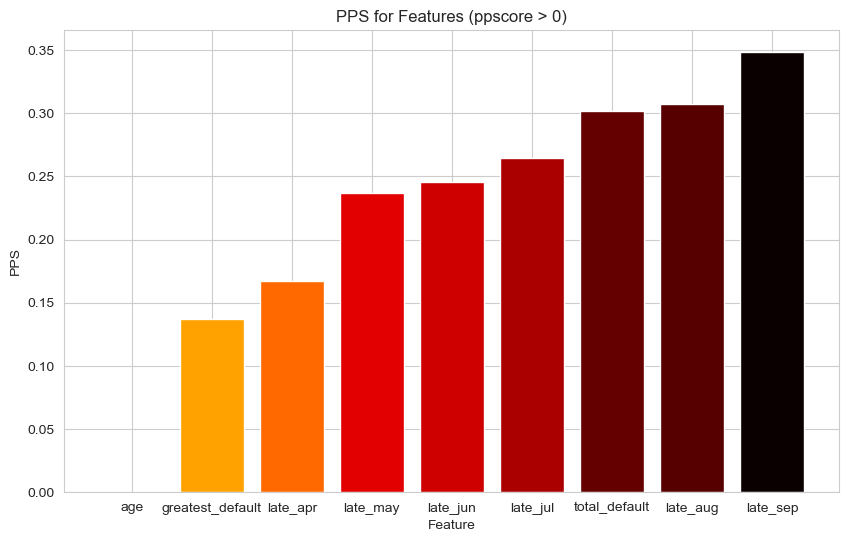

In [60]:
import matplotlib.pyplot as plt

filtered_pps_matrix = pps_matrix[pps_matrix['ppscore'] > 0].sort_values(by='ppscore', ascending=True)
colormap = plt.cm.get_cmap('hot_r')

normalised_scores = (filtered_pps_matrix['ppscore'] - filtered_pps_matrix['ppscore'].min()) / (filtered_pps_matrix['ppscore'].max() - filtered_pps_matrix['ppscore'].min())

plt.figure(figsize=(10, 6))

for x, score, norm_score in zip(filtered_pps_matrix['x'], filtered_pps_matrix['ppscore'], normalised_scores):
    color = colormap(norm_score)
    plt.bar(x, score, color=color)
plt.xlabel('Feature')
plt.ylabel('PPS')
plt.title('PPS for Features (ppscore > 0)')
plt.show()


This becomes more interesting, since although the PPS scores are not especially high, with the greatest value being 0.35 out of a maximum possible value of 1, we do see that the more recently a customer has defaulted, the better a predictor this is that they will default again in the next month.
* For this reason, it seems likely to be worth including `late_aug` and `late_sep` in further analysis, since these have the highest PPS and were also found to be relatively high in the correlation study above.

---

# Data Exploration 4: Exploratory Data Analysis on selected variables

Considering the findings of the correlation study and PPS analysis, the variables that are worth further study have been selected:

In [14]:
vars_to_study = ['any_default', 'credit_limit', 'greatest_default', 'late_aug', 'late_sep', 'total_default']
vars_to_study

['any_default',
 'credit_limit',
 'greatest_default',
 'late_aug',
 'late_sep',
 'total_default']

In [15]:
df_eda = df.filter(vars_to_study + ['default_next_month'])
df_eda.head()

any_default  credit_limit  greatest_default  late_aug  late_sep  \
0            1       20000.0                 2         2         2   
1            1      120000.0                 2         2        -1   
2            0       90000.0                 0         0         0   
3            0       50000.0                 0         0         0   
4            0       50000.0                 0         0        -1   

   total_default  default_next_month  
0              4                   1  
1              4                   1  
2              0                   0  
3              0                   0  
4              0                   0

The distribution is plotted coloured by `default_next_month`
* Note that the following code cell is adapted from CI's WP02 "Churnometer"
* Also note that in order for graphs to display correctly, the backend of matplotlib is first set to inline

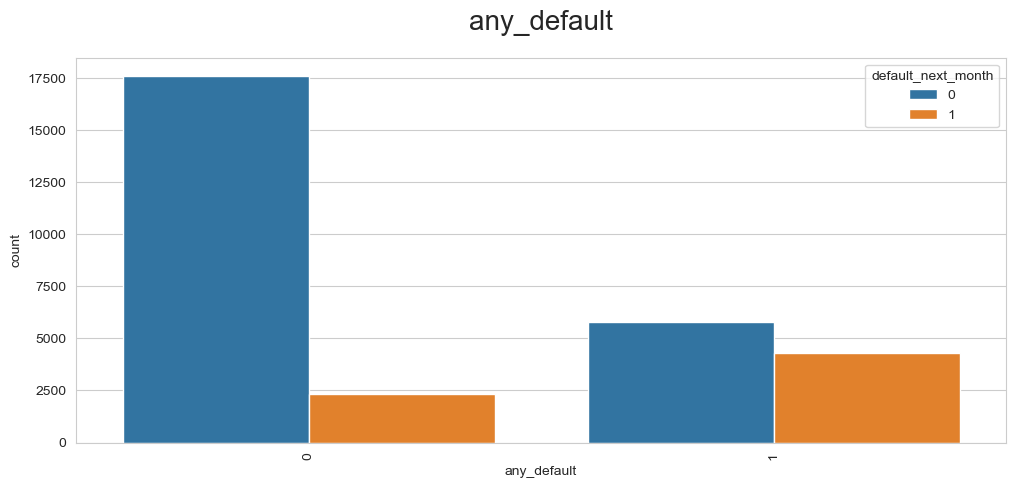

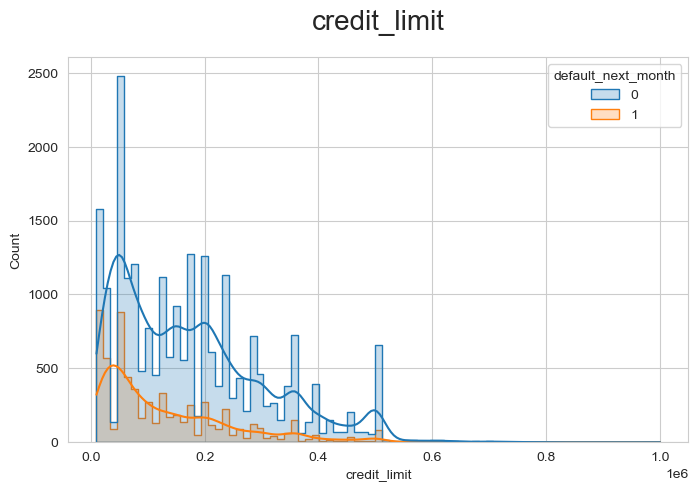

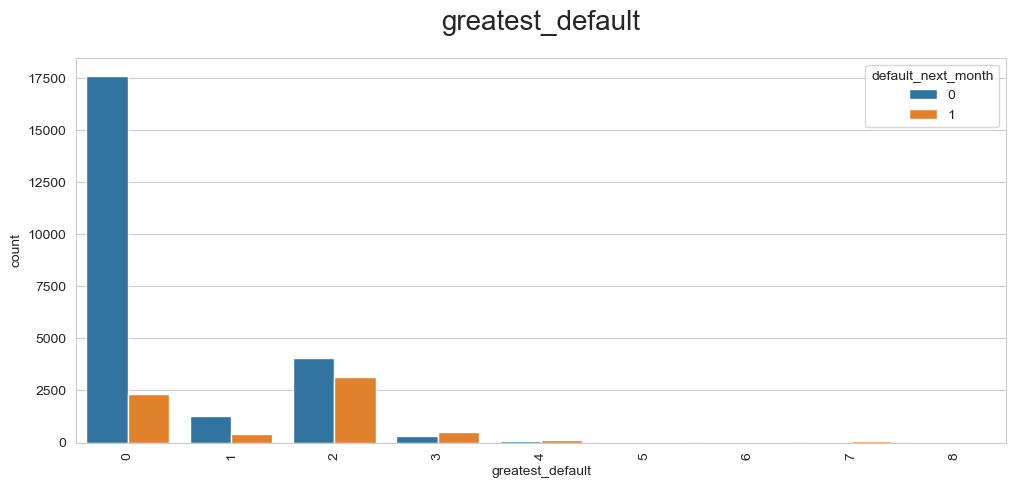

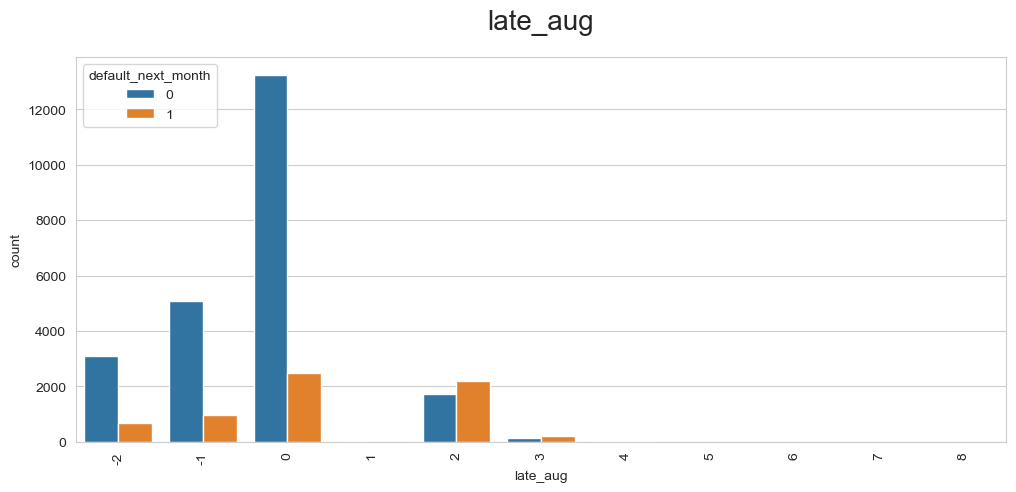

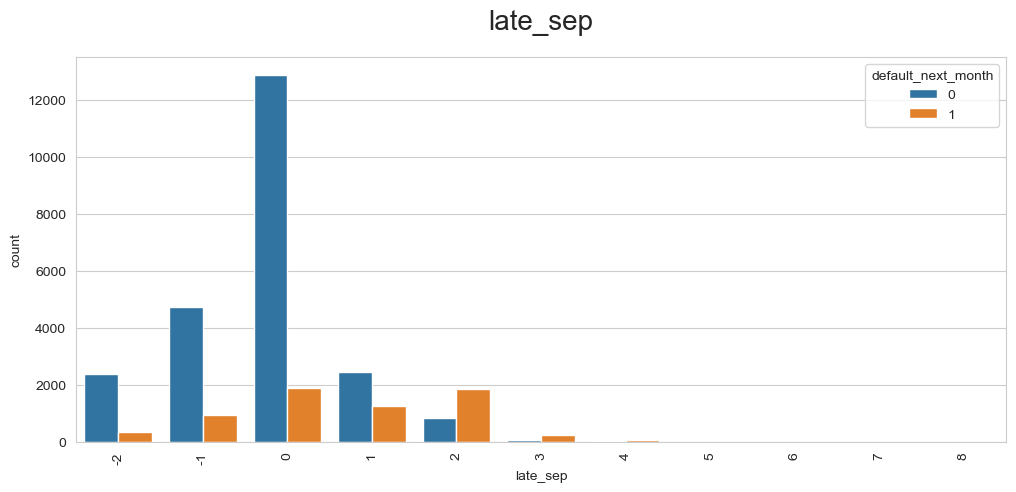

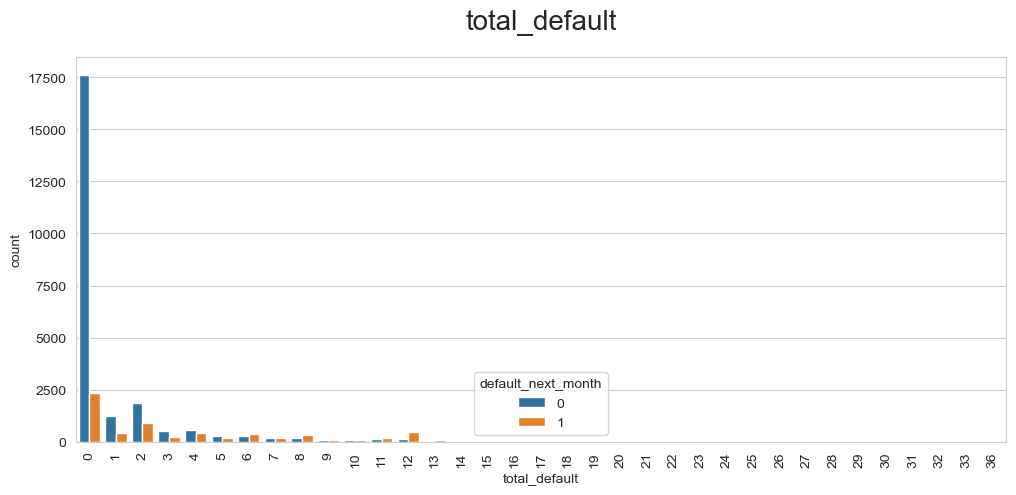

In [49]:
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

def plot_categorical(df, col, target_var):
    plt.figure(figsize=(12, 5))
    sns.countplot(data=df, x=col, hue=target_var)
    plt.xticks(rotation=90)
    plt.title(f"{col}", fontsize=20, y=1.05)
    plt.show()


def plot_numerical(df, col, target_var):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=col, hue=target_var, kde=True, element="step")
    plt.title(f"{col}", fontsize=20, y=1.05)
    plt.show()


target_var = 'default_next_month'
for col in vars_to_study:
    if  col in ['any_default', 'greatest_default', 'late_aug', 'late_sep', 'total_default']:
        plot_categorical(df_eda, col, target_var)
        print("\n\n")
    else:
        plot_numerical(df_eda, col, target_var)
        print("\n\n")


From the graphs above, we see that customers who default in the following month tend to have:
* A previous default at some point within their history
* A relatively low credit limit
* Higher values for their greatest default than other customers
* Higher payment delays during August and September than other customers
* A higher total default value than other customers

We might also consider viewing these data as a scatter matrix.
* `late_aug` is removed from the graphs, since it shows lower correlation levels with `default_next_month `than `late_sep`, and the graphs display more clearly with fewer variables included

In [68]:
import plotly.express as px
fig = px.scatter_matrix(data_frame=df,
                        dimensions=['any_default', 'credit_limit', 'greatest_default', 'late_sep', 'total_default'],
                        color='default_next_month',
                        )
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,)
fig.show()

---

# Data Exploration 5: Additional Data Visualisations

The following graphs supplement the above analysis, showing a more complete picture of the relationship between different variables
* They are not included in the sections above to avoid presenting too much information at once, given this information may or may not be relevant
* Note that the following code cells are adapted from CI's WP02 "Churnometer"
* Also note that in order for graphs to display correctly, the backend of matplotlib is first set to inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis_r', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML model is correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated between one another")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("This evaluates the monotonic relationship between variables \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)


In [70]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

c:\Users\franc\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=4.

c:\Users\franc\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=4.

c:\Users\franc\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=4.

c:\Users\franc\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=4.

c:\Users\franc\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning:

The least populated class in y has only 3 m

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  700.0  0.052  0.137  0.0  0.0  0.0  0.025  0.935




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



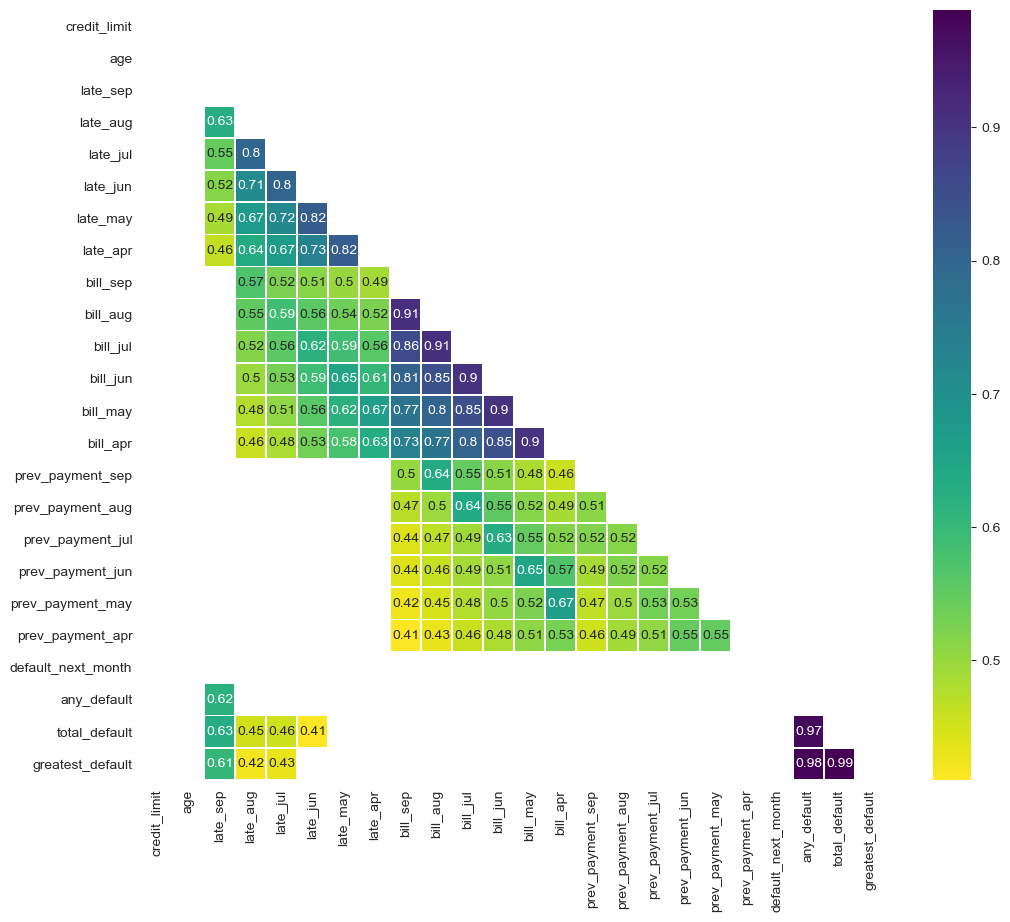



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



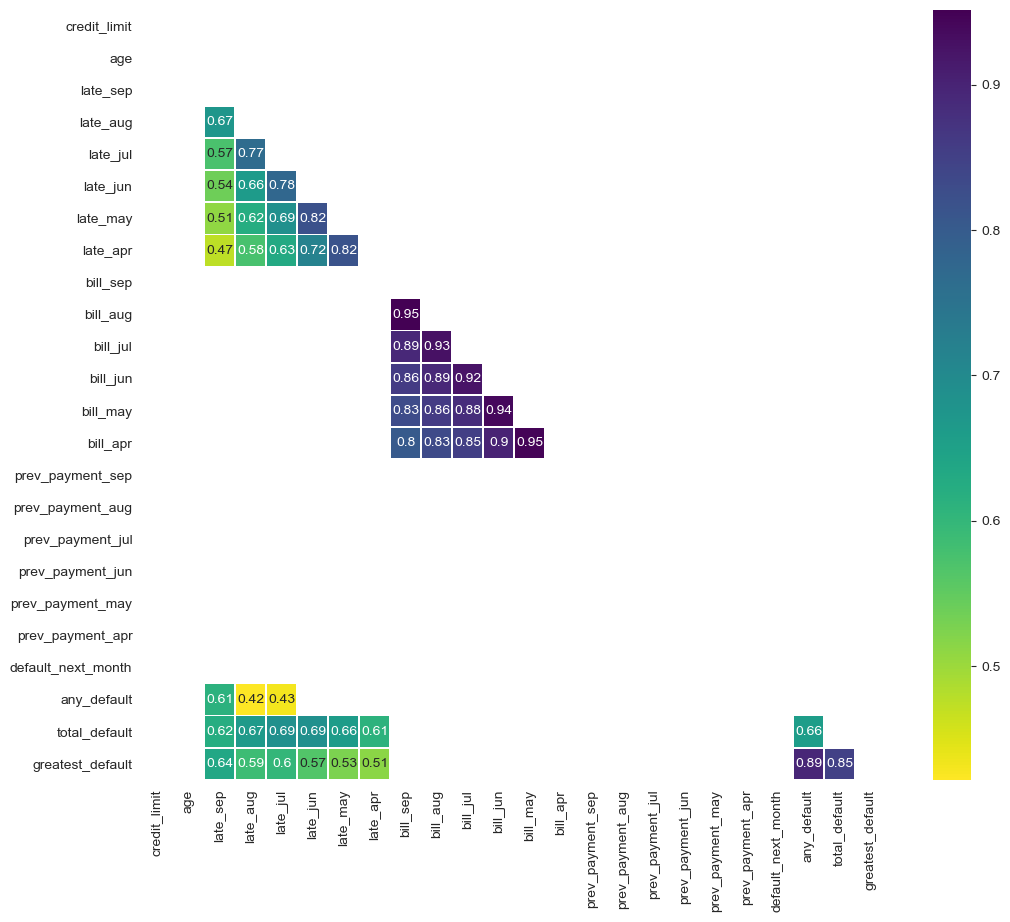



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



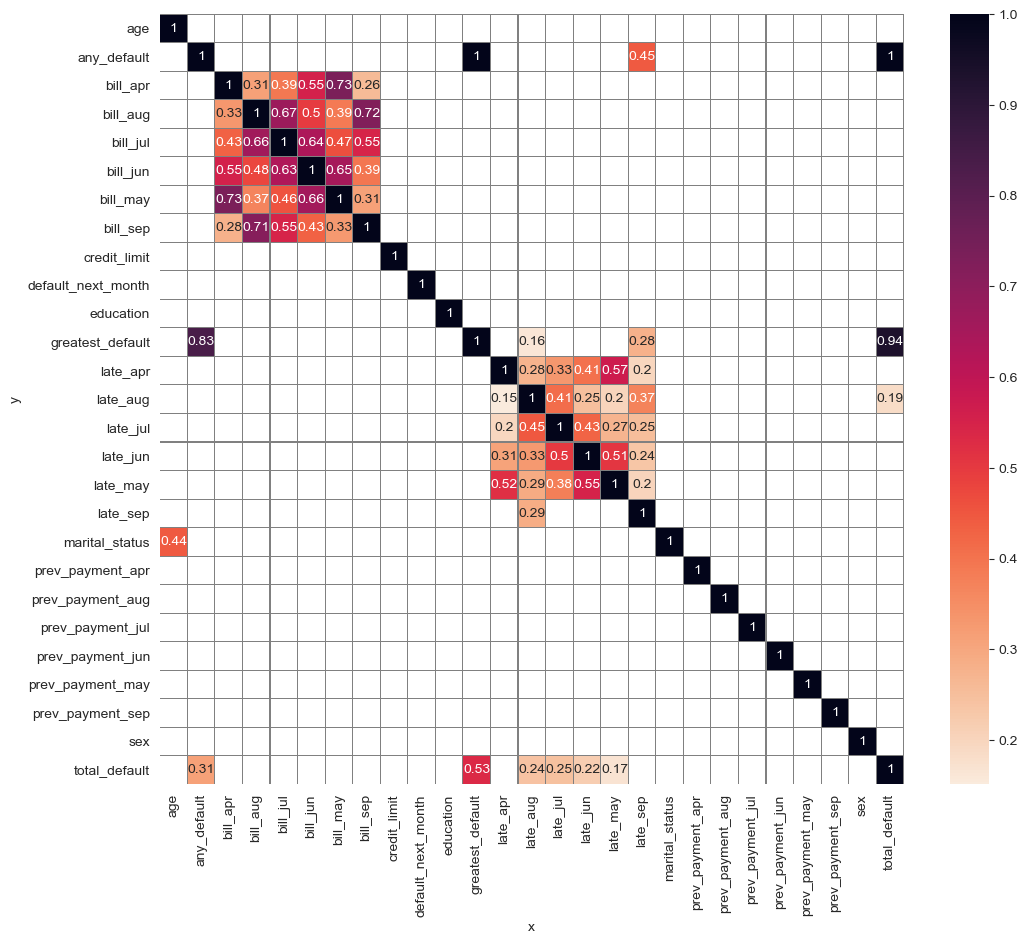

In [74]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.15,
                  figsize=(12,10), font_annot=10)

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [18]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)


IndentationError: expected an indented block (2852421808.py, line 5)